In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load packages

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile
import tensorflow_addons as tfa

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### parameters

In [5]:
dataset = "cifar10"
labels_per_class = 256 # 'full'
n_latent_dims = 1024
confidence_threshold = 0.8 # minimum confidence to include in UMAP graph for learned metric
learned_metric = True # whether to use a learned metric, or Euclidean distance between datapoints

augmented = True #
min_dist= 0.001 # min_dist parameter for UMAP
negative_sample_rate = 5 # how many negative samples per positive sample 
batch_size = 128 # batch size 
optimizer = tf.keras.optimizers.Adam(1e-3) # the optimizer to train
optimizer = tfa.optimizers.MovingAverage(optimizer)
label_smoothing = 0.2 # how much label smoothing to apply to categorical crossentropy
max_umap_iterations = 50 # how many times, maximum, to recompute UMAP
max_epochs_per_graph = 500 # how many epochs maximum each graph trains for (without early stopping)
umap_patience = 5 # how long before recomputing UMAP graph

#### Load dataset

In [6]:
from tfumap.semisupervised_keras import load_dataset

In [7]:
(
    X_train,
    X_test,
    X_labeled,
    Y_labeled,
    Y_masked,
    X_valid,
    Y_train,
    Y_test,
    Y_valid,
    Y_valid_one_hot,
    Y_labeled_one_hot,
    num_classes,
    dims
) = load_dataset(dataset, labels_per_class)

### load architecture

In [8]:
from tfumap.semisupervised_keras import load_architecture

In [9]:
encoder, classifier, embedder = load_architecture(dataset, n_latent_dims)

### load pretrained weights

In [10]:
from tfumap.semisupervised_keras import load_pretrained_weights

In [11]:
encoder, classifier = load_pretrained_weights(dataset, augmented, labels_per_class, encoder, classifier)

W0811 23:19:50.580809 139710218004224 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f0fcec1f4a8> and <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f0fcec1f940>).
W0811 23:19:50.584301 139710218004224 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f0fcec2e9e8> and <tensorflow.python.keras.layers.advanced_activations.

W0811 23:19:50.702107 139710218004224 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.wrappers.WeightNormalization object at 0x7f0fce8fac50> and <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0fce8faf28>).
W0811 23:19:50.706274 139710218004224 base.py:272] Inconsistent references when loading the checkpoint into this object graph. Either the Trackable object references in the Python program have changed in an incompatible way, or the checkpoint was generated in an incompatible program.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0fce8faf28> and <tensorflow.python.keras.layers.adv

#### compute pretrained accuracy

In [12]:
# test current acc
pretrained_predictions = classifier.predict(encoder.predict(X_test, verbose=True), verbose=True)
pretrained_predictions = np.argmax(pretrained_predictions, axis=1)
pretrained_acc = np.mean(pretrained_predictions == Y_test)
print('pretrained acc: {}'.format(pretrained_acc))

313/313 [==============================] - 1s 2ms/step
pretrained acc: 0.7664


### get a, b parameters for embeddings

In [13]:
from tfumap.semisupervised_keras import find_a_b

In [14]:
a_param, b_param = find_a_b(min_dist=min_dist)

### build network

In [15]:
from tfumap.semisupervised_keras import build_model

In [16]:
model = build_model(
    batch_size,
    a_param,
    b_param,
    dims,
    embedder,
    encoder,
    classifier,
    negative_sample_rate=negative_sample_rate,
    optimizer=optimizer,
    label_smoothing=label_smoothing,
)

### build labeled iterator

In [17]:
from tfumap.semisupervised_keras import build_labeled_iterator

In [18]:
labeled_dataset = build_labeled_iterator(X_labeled, Y_labeled_one_hot, augmented, dims)

### training

In [19]:
from livelossplot import PlotLossesKerasTF
from tfumap.semisupervised_keras import get_edge_dataset
from tfumap.semisupervised_keras import zip_datasets

#### callbacks

In [20]:
# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_classifier_acc', min_delta=0, patience=15, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

# plot losses callback
groups = {'acccuracy': ['classifier_accuracy', 'val_classifier_accuracy'], 'loss': ['classifier_loss', 'val_classifier_loss']}
plotlosses = PlotLossesKerasTF(groups=groups)

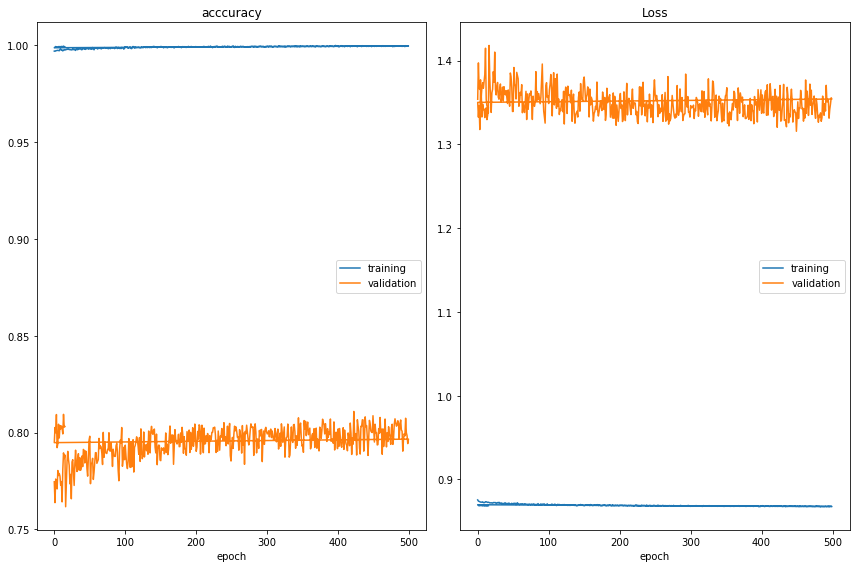

acccuracy
	training         	 (min:    0.997, max:    1.000, cur:    0.999)
	validation       	 (min:    0.762, max:    0.811, cur:    0.803)
Loss
	training         	 (min:    0.867, max:    0.876, cur:    0.869)
	validation       	 (min:    1.316, max:    1.418, cur:    1.344)
312/312 [==============================] - 70s 223ms/step - loss: 1.0624 - classifier_loss: 0.8686 - umap_loss: 0.1938 - classifier_accuracy: 0.9991 - val_loss: 1.3435 - val_classifier_loss: 1.3435 - val_umap_loss: 0.0000e+00 - val_classifier_accuracy: 0.8031
Epoch 17/500
183/312 [================>.............] - ETA: 24s - loss: 1.0608 - classifier_loss: 0.8682 - umap_loss: 0.1926 - classifier_accuracy: 0.9994

KeyboardInterrupt: 

In [22]:
current_validation_acc = 0
batches_per_epoch = np.floor(len(X_train)/batch_size).astype(int)
epochs_since_last_improvement = 0
for current_umap_iterations in tqdm(np.arange(max_umap_iterations)):
    
    # make dataset
    edge_dataset = get_edge_dataset(
        model,
        classifier,
        encoder,
        X_train,
        Y_masked,
        batch_size,
        confidence_threshold,
        labeled_dataset,
        dims,
        learned_metric = learned_metric
    )
    
    # zip dataset
    zipped_ds = zip_datasets(labeled_dataset, edge_dataset, batch_size)
    
    # train dataset
    history = model.fit(
        zipped_ds,
        epochs=max_epochs_per_graph,
        validation_data=(
            (X_valid, tf.zeros_like(X_valid), tf.zeros_like(X_valid)),
            {"classifier": Y_valid_one_hot},
        ),
        callbacks = [early_stopping, plotlosses],
        max_queue_size = 100,
        steps_per_epoch = batches_per_epoch,
        #verbose=0
    )
    
    # get validation acc
    pred_valid = classifier.predict(encoder.predict(X_valid))
    new_validation_acc = np.mean(np.argmax(pred_valid, axis = 1) == Y_valid)
    
    # if validation accuracy has gone up, mark the improvement
    if new_validation_acc > current_validation_acc:
        epochs_since_last_improvement = 0
        current_validation_acc = copy.deepcopy(new_validation_acc)
    else:
        epochs_since_last_improvement += 1
        
    if epochs_since_last_improvement > umap_patience:
        print('No improvement in {} UMAP iterators'.format(umap_patience))
        break

In [23]:
class_pred = classifier.predict(encoder.predict(X_test))
class_acc = np.mean(np.argmax(class_pred, axis=1) == Y_test)
print(class_acc)

0.7979
